In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from os import listdir
from os.path import isfile, join, isdir
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes
import math
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext

ModuleNotFoundError: No module named 'geopandas'

# Data exploration

As soon as we will do most of the work on the cluster, here we will show how we deal with data on a small subsample (`data_min`)

In [2]:
# create the session
spark = SparkSession.builder.getOrCreate()

# create the context
sc = spark.sparkContext

In [3]:
from pyspark.sql.types import *

In [4]:
schema = StructType([StructField('Country', StringType(), True),
                     StructField('Namespace', StringType(), True),
                     StructField('AirQualityNetwork', StringType(), True),
                     StructField('AirQualityStation', StringType(), True),
                     StructField('EoICode', StringType(), True),
                     StructField('SamplingPoint', StringType(), True),
                     StructField('SamplingProcess', StringType(), True),
                     StructField('Sample', StringType(), True),
                     StructField('Pollutant', StringType(), True),
                     StructField('AirPollutantCode', StringType(), True),
                     StructField('AveragingTime', StringType(), True),
                     StructField('Concentration', FloatType(), True),
                     StructField('Unit', StringType(), True),
                     StructField('DatetimeBegin', TimestampType(), True),
                     StructField('DatetimeEnd', TimestampType(), True),
                     StructField('Validity', IntegerType(), True),
                     StructField('Verification', IntegerType(), True)])

In [5]:
df = spark.read.format("com.databricks.spark.csv").option("inferSchema", "true") \
.option("timestampFormat", "yyyy-mm-dd hh:mm:ss XXX") \
.csv('./data_min/*/*', schema=schema, header=True) \
.drop("Namespace", "AirQualityStation", "AirQualityNetwork", "SamplingPoint", "SamplingProcess", "Sample", "AirPollutantCode")

Now the schema is the following:

| Field         | Type      | Description                                                    |
|---------------|-----------|----------------------------------------------------------------|
| Country       | String    | 2-letter country code                                          |
| EoICode       | String    | Unique station identifier                                      |
| Pollutant     | String    | Short name of pollutant                                        |
| AveragingTime | String    | Time for which the measurement has been taken (hour, day, etc) |
| Concentration | Float     | The measured value/concentration                               |
| Unit          | String    | Defines the unit of the concentration                          |
| DatetimeBegin | Timestamp | Start time (yyyy-mm-dd hh:mm:ss Z) of the measurement          |
| DatetimeEnd   | Timestamp | End time (yyyy-mm-dd hh:mm:ss Z) of the measurement            |
| Validity      | Integer   | The validity flag for the measurement                          |
| Verification  | Integer   | The verification flag for the measurement.                     |

In [6]:
df.show(10)

+-------+-------+---------+-------------+-------------+-----+-------------------+-------------------+--------+------------+
|Country|EoICode|Pollutant|AveragingTime|Concentration| Unit|      DatetimeBegin|        DatetimeEnd|Validity|Verification|
+-------+-------+---------+-------------+-------------+-----+-------------------+-------------------+--------+------------+
|     MK|MK0031A|       CO|         hour|         1.38|mg/m3|2013-01-10 16:00:00|2013-01-10 17:00:00|       1|           1|
|     MK|MK0031A|       CO|         hour|         1.48|mg/m3|2013-01-24 17:00:00|2013-01-24 18:00:00|       1|           1|
|     MK|MK0031A|       CO|         hour|         3.25|mg/m3|2013-01-10 04:00:00|2013-01-10 05:00:00|       1|           1|
|     MK|MK0031A|       CO|         hour|          2.8|mg/m3|2013-01-09 17:00:00|2013-01-09 18:00:00|       1|           1|
|     MK|MK0031A|       CO|         hour|         3.69|mg/m3|2013-01-10 03:00:00|2013-01-10 04:00:00|       1|           1|
|     MK

*Validity* can take 5 different values:  
**-99** - Not valid due to station maintenance or calibration  
**-1** - Not valid  
**1** - Valid  
**2** - Valid, but below detection limit measurement value given  
**3** - Valid, but below detection limit and number replaced by 0.5 * detection_limit

*Verificaton* can take 3 different values:  
**1** - Verified  
**2** - Preliminary verified  
**3** - Not verified

We found one type of missing and incorrect values which is not covered by validity-verification pair: measurement value below zero. Also, sometimes a measurement unit is indicated improperly but it is not the case in our "mini" dataset.

In [7]:
df.select("*").where(df.Concentration < 0).show(5)

+-------+-------+---------+-------------+-------------+-----+-------------------+-------------------+--------+------------+
|Country|EoICode|Pollutant|AveragingTime|Concentration| Unit|      DatetimeBegin|        DatetimeEnd|Validity|Verification|
+-------+-------+---------+-------------+-------------+-----+-------------------+-------------------+--------+------------+
|     MK|MK0030A|       CO|         hour|        -0.01|mg/m3|2013-01-09 14:00:00|2013-01-09 15:00:00|       1|           1|
|     MK|MK0030A|       CO|         hour|        -0.01|mg/m3|2013-01-09 14:00:00|2013-01-09 15:00:00|       1|           1|
|     MK|MK0034A|      SO2|         hour|         -0.1|µg/m3|2013-01-26 07:00:00|2013-01-26 08:00:00|       1|           1|
|     MK|MK0034A|      SO2|         hour|         -0.1|µg/m3|2013-01-26 07:00:00|2013-01-26 08:00:00|       1|           1|
|     MK|MK0046A|       CO|         hour|        -0.06|mg/m3|2013-01-06 06:00:00|2013-01-06 07:00:00|       1|           1|
+-------

Other inconsistencies, including `null` values are covered:

In [8]:
df.select("*").where(df.Concentration.isNull()).show(5)

+-------+-------+---------+-------------+-------------+-----+-------------------+-------------------+--------+------------+
|Country|EoICode|Pollutant|AveragingTime|Concentration| Unit|      DatetimeBegin|        DatetimeEnd|Validity|Verification|
+-------+-------+---------+-------------+-------------+-----+-------------------+-------------------+--------+------------+
|     GB|GB0906A|       CO|         hour|         null|mg/m3|2018-01-19 15:00:00|2018-01-19 16:00:00|      -1|           1|
|     GB|GB0906A|       CO|         hour|         null|mg/m3|2018-01-19 16:00:00|2018-01-19 17:00:00|      -1|           1|
|     GB|GB0906A|       CO|         hour|         null|mg/m3|2018-01-06 15:00:00|2018-01-06 16:00:00|      -1|           1|
|     GB|GB0906A|       CO|         hour|         null|mg/m3|2018-01-06 16:00:00|2018-01-06 17:00:00|      -1|           1|
|     GB|GB0906A|       CO|         hour|         null|mg/m3|2018-01-07 11:00:00|2018-01-07 00:00:00|      -1|           1|
+-------

So, we have to filter those values in each query.

We have files containing all the information about the stations and the areas of European countries:

In [9]:
import chardet
RELATIVE_DATA_PATH = './data'
# Load metadata
metadata = pd.read_csv(join(RELATIVE_DATA_PATH, 'metadata.csv'), sep='\t')
area = pd.read_csv('area.csv')

`metadata.csv` has the following structure

| Field                    | Type    | Description                                                                                                               |
|--------------------------|---------|---------------------------------------------------------------------------------------------------------------------------|
| Countrycode              | String  | Country iso code                                                                                                          |
| Namespace                | String  | Namespace of network                                                                                                      |
| AirQualityNetwork        | String  | Network identifier                                                                                                        |
| AirQualityStation        | String  | Localid of station                                                                                                        |
| AirQualityNatCode        | String  | National code of station                                                                                                  |
| AirQualityStationEoICode | String  | Station EoI code as used in the past AirBase system                                                                       |
| AirQualityStationArea    | String  | Reference to area code. Full list at http://dd.eionet.europa.eu/vocabulary/aq/areaclassification/view                     |
| SamplingPoint            | String  | Localid of samplingpoint                                                                                                  |
| SamplingProcess          | String  | Localid of process                                                                                                        |
| Sample                   | String  | Localid of sample (also known as feature of interest)                                                                     |
| BuildingDistance         | Integer | Distance to building (m). Value of -999 indicate unknown                                                                  |
| EquivalenceDemonstrated  | String  | Reference to demonstrated equivalence. Full list at http://dd.eionet.europa.eu/vocabulary/aq/equivalencedemonstrated/view |
| InLetHeight              | Integer | Height of inlet (m). Value of -999 indicate unknown                                                                       |
| KerpDistance             | Integer | Distance to kerp (m). Value of -999 indicate unknown                                                                      |
| MeasurementEquipment     | String  | Refernce (URL) to measurement equipment                                                                                   |
| MeasurementType          | String  | Reference to measurement type (full list at http://dd.eionet.europa.eu/vocabulary/aq/measurementtype/view)                |
| MeasurementMethod        | String  | Reference to measurement method (full list at http://dd.eionet.europa.eu/vocabulary/aq/measurementmethod/view)            |
| AirPollutantCode         | String  | Reference (URL) to pollutant definition in data dictionary                                                                |
| AirPollutant             | String  | Short pollutant name measured at this samplingpoint                                                                       |
| AirQualityStationType    | String  | Short name of station type (full list at http://dd.eionet.europa.eu/vocabulary/aq/stationclassification/view)             |
| Projection               | String  | Reference to projection                                                                                                   |
| Longitude                | Decimal | Longitude of samplingpoint                                                                                                |
| Latitude                 | Decimal | Latitude of samplingpoint                                                                                                 |
| Altitude                 | Integer | Altitude of samplingpoint (m)  

Some columns in `metadata` contain missing values but we do not need them, so no additional preprocessing is required.

In [10]:
metadata.sample(5)

,Countrycode,Timezone,Namespace,AirQualityNetwork,AirQualityStation,AirQualityStationEoICode,AirQualityStationNatCode,SamplingPoint,SamplingProces,Sample,...,Latitude,Altitude,MeasurementType,AirQualityStationType,AirQualityStationArea,EquivalenceDemonstrated,MeasurementEquipment,InletHeight,BuildingDistance,KerbDistance
17995,ES,http://dd.eionet.europa.eu/vocabulary/aq/timez...,ES.BDCA.AQD,NET_ES058A,STA_ES0001R,ES0001R,45153999,SP_45153999_402_M,SPP_45153999_402_M.1,SAM_45153999_402_M,...,39.546940,917.0,active,background,rural,ref,NaN,5.0,-999.0,-999.0
18674,ES,http://dd.eionet.europa.eu/vocabulary/aq/timez...,ES.BDCA.AQD,NET_ES201A,STA_ES0629A,ES0629A,11008003,SP_11008003_10_49,SPP_11008003_10_49.1,SAM_11008003_10_49,...,36.185620,30.0,automatic,industrial,urban,yes,http://dd.eionet.europa.eu/vocabulary/aq/measu...,4.0,-999.0,-999.0
5733,BE,http://dd.eionet.europa.eu/vocabulary/aq/timez...,BE.CELINE-IRCEL.AQ,NET-Wallonia,STA-BETR201,BETR201,43R201,SPO-BETR201_00007_100,SPP-BETR201_00007,SAM-BETR201_00007,...,50.628646,65.0,NaN,background,urban,NaN,NaN,3.0,-999.0,-999.0
66,AL,http://dd.eionet.europa.eu/vocabulary/aq/timez...,AL.AEF.AQ,NET-AL001A,STA-AL0207A,AL0207A,AL310A01,SPO-AL0207A_00020_100,SPP-AL_A_GC-FID_GC955,SPO_F-AL0207A_00020_100_100,...,41.110980,150.0,automatic,traffic,urban,ref,http://dd.eionet.europa.eu/vocabulary/aq/measu...,3.0,1.0,3.0
6374,BE,http://dd.eionet.europa.eu/vocabulary/aq/timez...,BE.CELINE-IRCEL.AQ,NET-Wallonia,STA-BEVN070,BEVN070,50N070,SPO-BEVN070_00443_100,SPP-BEVN070_00443_1,NaN,...,50.465192,30.0,automatic,background,suburban,ref,NaN,-999.0,-999.0,-999.0


# Station densities

We began our analysis with calculating the total number of stations and the station densities per km2

In [11]:
# Total number of stations
metadata.AirQualityStationEoICode.nunique()

5739

We also tried map visualization but faced into some issues (JavaScript performance ...)

![title](maps/station-map.jpg)

Since we cannot really assess the station densities in this way, we decided to calculate them explicitly.

In [12]:
# calculate the densities (stations per 1000 km2)
stations_per_country = metadata.groupby('Countrycode').AirQualityStationEoICode.nunique()
stations_per_area = area.join(stations_per_country, on='Countrycode')
stations_per_area['density'] = stations_per_area['AirQualityStationEoICode'] * 1000 / stations_per_area['Area']
stations_per_area.rename(columns={'AirQualityStationEoICode': 'stations'}, inplace=True)
stations_per_area.sort_values(['density'], ascending=0)

,name,Countrycode,id,Area,stations,density
16,Gibraltar,GI,GIB,6.5,3,461.538462
28,Malta,MT,MLT,316.0,5,15.822785
4,Belgium,BE,BEL,30528.0,290,9.499476
0,Andorra,AD,AND,468.0,3,6.410256
24,Luxembourg,LU,LUX,2586.0,13,5.027069
8,Czechia,CZ,CZE,78868.0,204,2.586600
2,Austria,AT,AUT,83879.0,204,2.432075
29,Netherlands,NL,NLD,41540.0,99,2.383245
22,Italy,IT,ITA,302073.0,718,2.376909
9,Germany,DE,DEU,357376.0,776,2.171383


As we can see, small countries (obviously) have higher station densities but some bigger countries (Belgium, Czech Republic, Austria) challenge the leadership.

# Data analysis

In [13]:
# Load data
countries = [f for f in listdir(RELATIVE_DATA_PATH) if isdir(join(RELATIVE_DATA_PATH, f))]

frames = []
for country in countries:
    print(f"Parsing {country}")
    pollutantsPath = join(RELATIVE_DATA_PATH, country)
    pollutants = [f for f in listdir(pollutantsPath) if isdir(join(pollutantsPath, f)) ]
    
    for pollutant in pollutants:
        print(f"Parsing pollutant {pollutant}")
        pollutantPath = join(pollutantsPath, pollutant)
        dataCSVs = [f for f in listdir(pollutantPath)]
        
        for dataCSV in dataCSVs:
            dataCSVPath = join(pollutantPath, dataCSV)
            
            with open(dataCSVPath, 'rb') as f:
                info = chardet.detect(f.read()[:500])
                currentCSV = pd.read_csv(dataCSVPath, sep=',', encoding=info.get('encoding'))
                frames.append(currentCSV)
            
data = pd.concat(frames)

# Remove Redundant columns
data.drop('SamplingProcess', 1, inplace = True)
data.drop_duplicates(keep="last", inplace=True) 

# Convert data columns
data.DatetimeBegin = pd.to_datetime(data.DatetimeBegin)
data.DatetimeEnd = pd.to_datetime(data.DatetimeEnd)

# Set index
data.set_index(['DatetimeBegin'], inplace = True)

# Sort by index (by DatetimeBegin)
data.sort_index(inplace=True)


Parsing CH
Parsing pollutant CO
Parsing pollutant NO2
Parsing pollutant O3
Parsing pollutant PM10
Parsing pollutant PM2.5
Parsing pollutant SO2


In [14]:
# Join with metadata (get Longitude and Latitude)
metadataSubset = metadata[['Latitude', 'Longitude','Countrycode','SamplingPoint']]
metadataSubset = metadataSubset[ metadataSubset.Latitude.notna() & metadataSubset.Longitude.notna() ]
spatialData = pd.merge(data, metadataSubset, how='inner', left_on = ['Countrycode','SamplingPoint'], right_on =['Countrycode','SamplingPoint'])


Metadata


In [16]:
# Print shape of data
data.shape

(4381154, 15)

# Pollutants: 

We can see the following charts stating how different pollutants level affect our health.

![Pollutants levels description](img/pollutantsLevelsDescription.jpg)
![Pollutants levels ](img/pollutantsLevels.jpg)

At first, we are going to focus only on Switzerland (more exactly, an AirQualityStation around Lausanne) and explore different pollutants variation throughout time (both short term and long term).



In [17]:
# Get switzerland's data
switzerland = data[ data.Countrycode == 'CH']

# To do: Pick a station in Lausanne 
# It would be cool to analyze the place we are living
switzerlandPoint = switzerland[(switzerland.AirQualityStation == 'STA-CH0002R') & (switzerland.Validity > 0) & \
                               (switzerland.Concentration > 0)]
pollutants = data.AirPollutant.unique()

###  Histogram


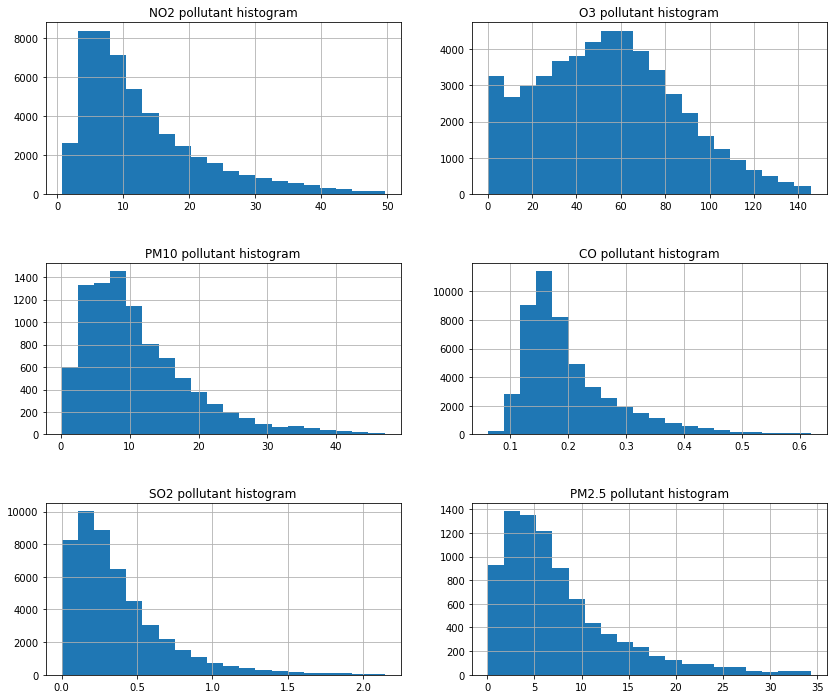

In [18]:
ncols = 2
nrows = len(pollutants) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(14, 4 * nrows))
plt.subplots_adjust(hspace = 0.4)

i = 0
j = 0
for pollutant in pollutants:
    pollutantData = switzerlandPoint[ switzerlandPoint.AirPollutant == pollutant ]
    quantile = pollutantData.Concentration.quantile(0.995)
    pollutantData[pollutantData.Concentration <= quantile].Concentration.hist(ax=axes[i // ncols, j], bins=20)
    axes[i // ncols, j].title.set_text(f"{pollutant} pollutant histogram")
    i += 1
    j += 1
    j %= ncols
    

### Variation plots (through all of history)


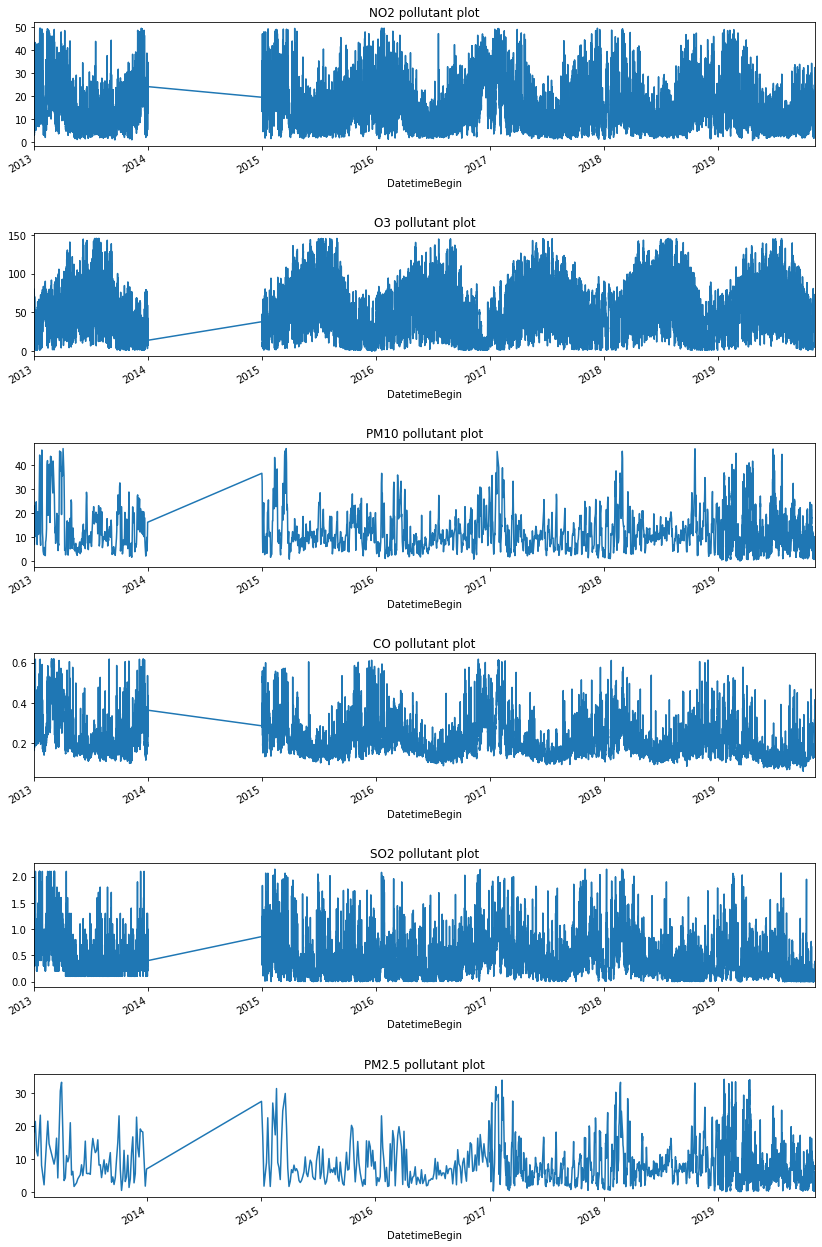

In [19]:
ncols = 1
nrows = len(pollutants)
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(14, 4 * nrows))
plt.subplots_adjust(hspace = 0.7)

i = 0
j = 0
for pollutant in pollutants:
    pollutantData = switzerlandPoint[ switzerlandPoint.AirPollutant == pollutant ]
    quantile = pollutantData.Concentration.quantile(0.995)
    pollutantData[pollutantData.Concentration <= quantile].Concentration.plot(ax=axes[i])
    axes[i].title.set_text(f"{pollutant} pollutant plot")
    i += 1
    j += 1


Here we can see that there is, for some reason, no data for 2014 year (c'est la vie !). Also we can observe some seasonal trends, for instance, an increase in NO2 and CO concentrations in winter and an increase of ozone concentration during the summer months.

### Going more in depth

We are trying to see correlations between the time of day.

During the night we can observe the lowest amount of NO2, oppositly the levels of NO2 seem to peak at evening. O3 level usually rises at night. Unfortunately, no other trends can be seen.

### 24hrs plots


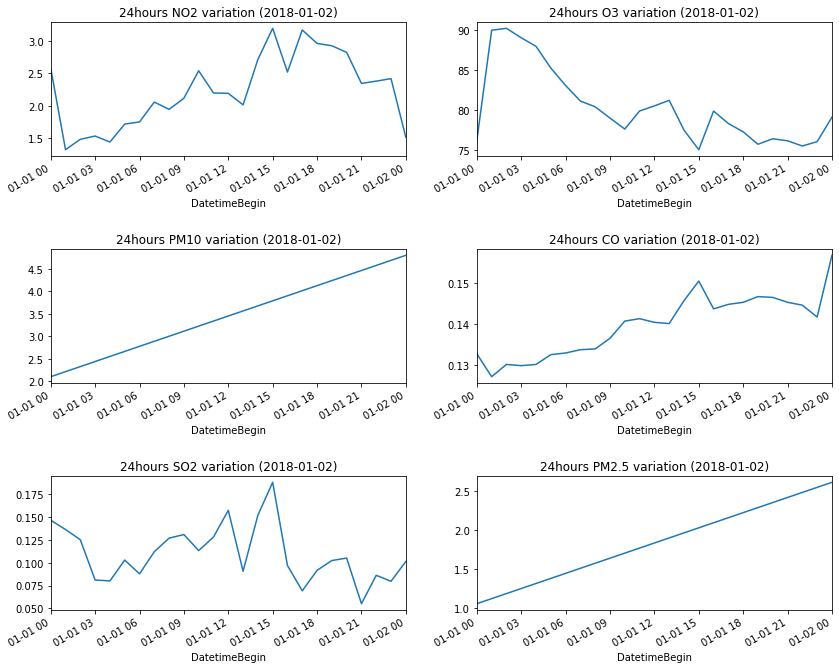

In [20]:
ncols = 2
nrows = len(pollutants) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(14, 4 * nrows))
plt.subplots_adjust(hspace = 0.7)
i = 0
j = 0
for pollutant in pollutants:
    pollutantData = switzerlandPoint[ switzerlandPoint.AirPollutant == pollutant ]
    pollutantData.loc['2018-01-01 00:00:00+0100':'2018-01-02 00:00:00+0100'].Concentration.plot(ax=axes[i // ncols, j])
    axes[i // ncols, j].title.set_text(f"24hours {pollutant} variation (2018-01-02)")
    i += 1
    j += 1
    j %= ncols
    
    

### 96hrs plots
Every color represents a different day.


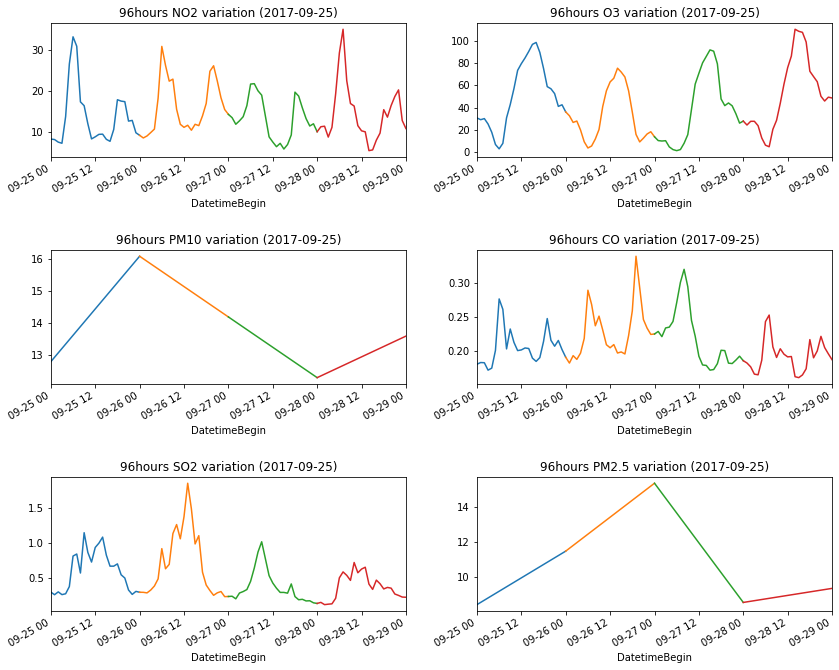

In [21]:
ncols = 2
nrows = len(pollutants) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(14, 4 * nrows))
plt.subplots_adjust(hspace = 0.7)

i = 0
j = 0
for pollutant in pollutants:
    pollutantData = switzerlandPoint[ switzerlandPoint.AirPollutant == pollutant ]
    try:
        pollutantData.loc['2017-09-25 00:00:00+0100':'2017-09-26 00:00:00+0100'].Concentration.plot(ax=axes[i // ncols, j])
        pollutantData.loc['2017-09-26 00:00:00+0100':'2017-09-27 00:00:00+0100'].Concentration.plot(ax=axes[i // ncols, j])
        pollutantData.loc['2017-09-27 00:00:00+0100':'2017-09-28 00:00:00+0100'].Concentration.plot(ax=axes[i // ncols, j])
        pollutantData.loc['2017-09-28 00:00:00+0100':'2017-09-29 00:00:00+0100'].Concentration.plot(ax=axes[i // ncols, j])
    except:
        pass
    axes[i // ncols, j].title.set_text(f"96hours {pollutant} variation (2017-09-25)")
    i += 1
    j += 1
    j %= ncols


Here we can observe that the daily trends mentioned before are actually repeating. However, PM10 and PM2.5 measurements are too sparse to make any conclusions.

### 1 year plots
Every color represents a different month.

We are trying to see what pollutant levels vary through a year. O3 levels for example are increasing during the summer. We validated this assumption by searching online for possible reasons and summer wildfire is the biggest cause of such an increase.O3 levels increasing during the summer. We validated this assumption by searching online for possible reasons and summer wildfire is the biggest cause of such an increase.

We have decided to dig deeper into O3 increased levels during the summer, thus we want to cross-reference the periods with elevated CO3 values with fire events, also load data from different countries that are closer to the sources of these fire and see if we can correlate a bigger increase in those areas (as they are closed to the source of the fires)

C:\Users\solda\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


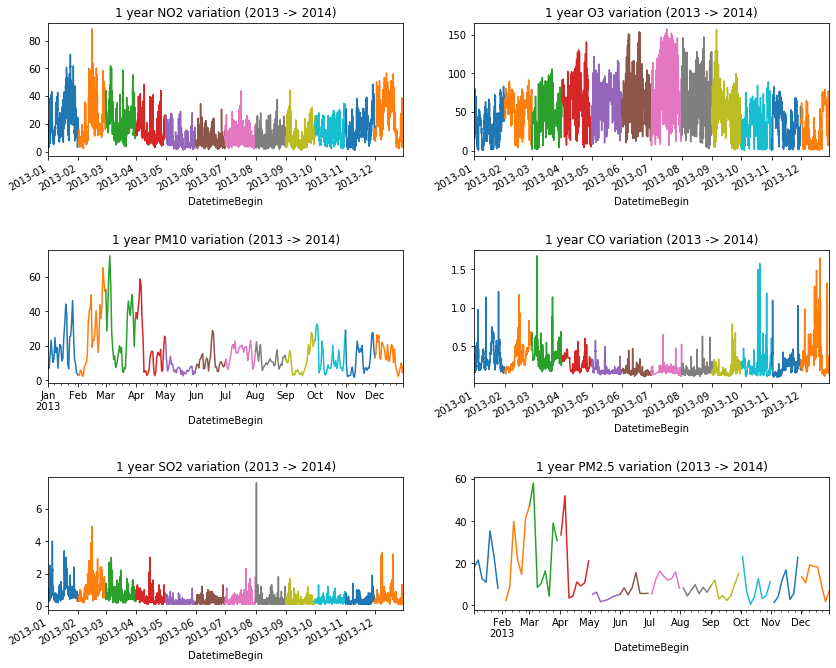

In [22]:
year = 2013
ncols = 2
nrows = len(pollutants) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(14, 4 * nrows))
plt.subplots_adjust(hspace = 0.7)

i = 0
j = 0
for pollutant in pollutants:
    pollutantData = switzerlandPoint[ switzerlandPoint.AirPollutant == pollutant ]
    quantile = pollutantData.Concentration.quantile(0.995)
    try:
        for x in range(11):
            fromTime = str(year) + '-'+ str(x + 1) +'-01 00:00:00+0100'
            untilTime = str(year) + '-'+ str(x + 2) +'-01 00:00:00+0100'
            pollutantData.loc[fromTime:untilTime].Concentration.plot(ax=axes[i // ncols, j])
        fromTime  = str(year) + '-12-01 00:00:00+0100'
        untilTime = str(year) + '-12-30 00:00:00+0100'
        pollutantData.loc[fromTime:untilTime].Concentration.plot(ax=axes[i // ncols, j])
    except:
        pass
    
    axes[i // ncols, j].title.set_text(f"1 year {pollutant} variation (2013 -> 2014)")
    i += 1
    j += 1
    j %= ncols


### Comparing trends between two distinct years (2013 and 2015)

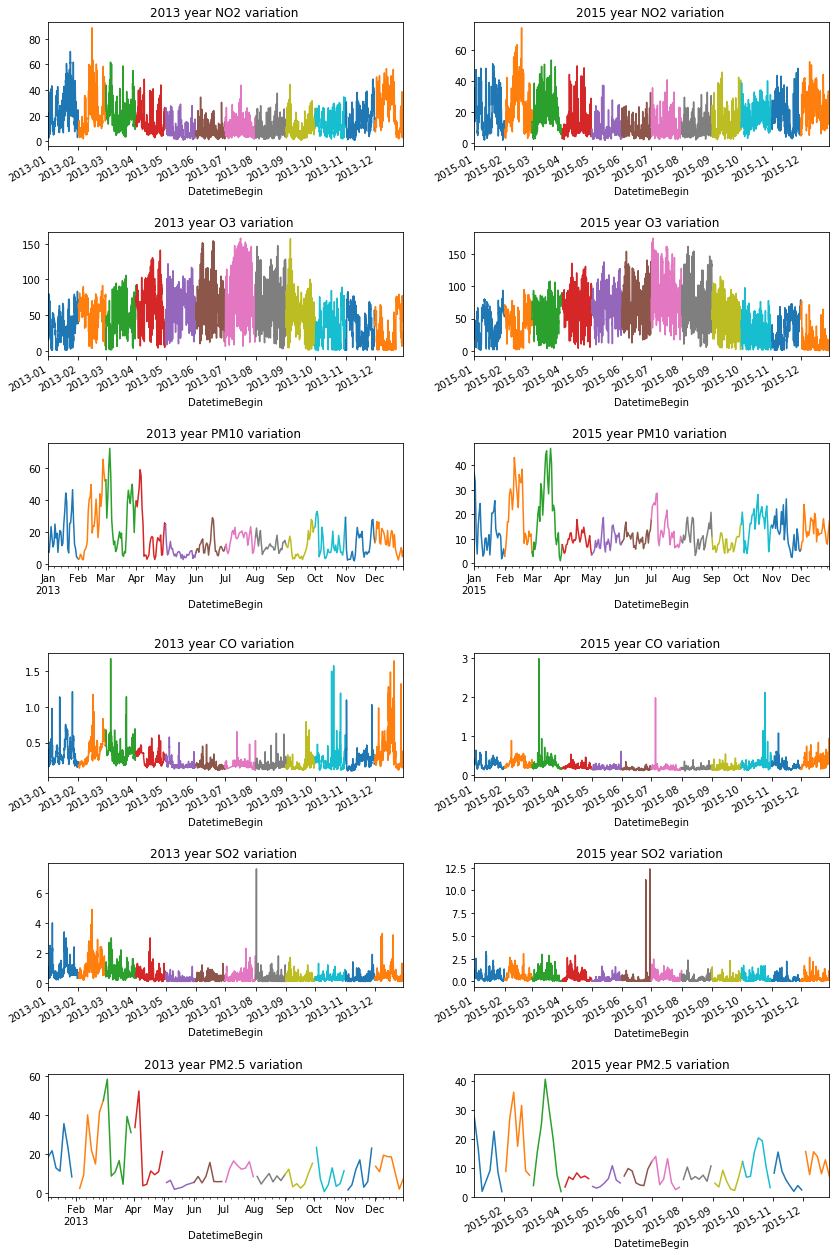

In [23]:
firstYear = 2013
secondYear = 2015
ncols = 2
nrows = len(pollutants)
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(14, 4 * nrows))
plt.subplots_adjust(hspace = 0.7)

i = 0
j = 0
for pollutant in pollutants:
    pollutantData = switzerlandPoint[switzerlandPoint.AirPollutant == pollutant]
    try:
        for x in range(11):
            fromTime = str(firstYear) + '-'+ str(x + 1) +'-01 00:00:00+0100'
            untilTime = str(firstYear) + '-'+ str(x + 2) +'-01 00:00:00+0100'
            pollutantData.loc[fromTime:untilTime].Concentration.plot(ax=axes[i, 0])
        fromTime  = str(firstYear) + '-12-01 00:00:00+0100'
        untilTime = str(firstYear) + '-12-30 00:00:00+0100'
        pollutantData.loc[fromTime:untilTime].Concentration.plot(ax=axes[i, 0])
        axes[i, 0].title.set_text(f"{firstYear} year {pollutant} variation ")
        
        for x in range(11):
            fromTime = str(secondYear) + '-'+ str(x + 1) +'-01 00:00:00+0100'
            untilTime = str(secondYear) + '-'+ str(x + 2) +'-01 00:00:00+0100'
            pollutantData.loc[fromTime:untilTime].Concentration.plot(ax=axes[i, 1])
        fromTime  = str(secondYear) + '-12-01 00:00:00+0100'
        untilTime = str(secondYear) + '-12-30 00:00:00+0100'
        pollutantData.loc[fromTime:untilTime].Concentration.plot(ax=axes[i, 1])
        axes[i, 1].title.set_text(f"{secondYear} year {pollutant} variation ")
        
    except:
        pass
    
 
    i += 1
    j += 1
    j %= ncols



On the plots above we can observe that the yearly trends stay approximately the same.

## Placing data on the map

Now plot the monthly average concentrations (computed in Spark) on the interactive maps using TimestampedGeoJson and geometric shapes of the European countries.

In [24]:
import datetime
import folium
import json
from folium.plugins import TimestampedGeoJson
from branca.colormap import LinearColormap

avg_all = pd.read_csv("scripts/avg.csv", names=['Countrycode', 'Pollutant', 'Year', 'Month', 'Value'])
area = pd.read_csv("area.csv")
avg_with_codes = pd.merge(area, avg_all, on="Countrycode")

with open("json_data/world-countries.json", "r") as world_json:
    countries = json.load(world_json).get("features")
    world_json.close()
with open("json_data/complementary.json", "r") as compl_json:
    compl = json.load(compl_json)
    compl_json.close()

pollutants = ['CO', 'NO2', 'O3', 'PM10', 'PM2.5', 'SO2']
color_scale = np.array(['#ffffd9', '#edf8b1', '#c7e9b4', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#253494',
                        '#081d58'])
scales = {'CO': np.linspace(200, 1600, 8), 'NO2': np.linspace(10, 80, 8), 'O3': np.linspace(15, 120, 8),
          'PM10': np.linspace(15, 120, 8), 'PM2.5': np.linspace(10, 80, 8), 'SO2': np.linspace(10, 80, 8)}
geo_dict = {}

for country in countries:
    geo_dict[country.get("id")] = country.get("geometry")


def color_coding(value):
    index = np.digitize(value, bin_edges, right=True)
    return color_scale[index]


def create_date(year, month):
    return datetime.datetime(year, month, 1)


date_vectorized = np.vectorize(create_date)

for pollutant in pollutants:
    avg = avg_with_codes[avg_with_codes["Pollutant"] == pollutant].copy()
    bin_edges = scales[pollutant]
    avg["Color"] = avg["Value"].apply(color_coding)
    avg["Datetime"] = date_vectorized(avg["Year"], avg["Month"])
    features = []
    for idx, row in avg.iterrows():
        if str(row["id"]) in geo_dict:
            feature = {
                'type': 'Feature',
                'geometry': geo_dict[row["id"]],
                'properties': {
                    'time': str(row['Datetime']),
                    'style': {'color': row['Color']}
                }
            }
            features.append(feature)
            if row["id"] in ["DNK", "FRA", "ITA", "GBR", "GRC"]:
                for geometry in compl.get(row["id"]).get("geometries"):
                    feature_new = dict(feature)
                    feature_new["geometry"] = geometry
                    features.append(feature_new)
    new_map = folium.Map([50.736455, 17.666], zoom_start=4.5)

    TimestampedGeoJson(
        {'type': 'FeatureCollection',
         'features': features},
        period='P1M', duration='P1M',
        add_last_point=True,
        auto_play=False,
        loop=False,
        max_speed=1,
        loop_button=True,
        date_options='YYYY/MM',
        time_slider_drag_update=True
    ).add_to(new_map)
    colormap = LinearColormap(color_scale, vmin=0, vmax=bin_edges[-1])
    colormap.caption = "Monthly average " + pollutant + " (in µg/m3)"
    colormap.add_to(new_map)
    new_map.save("maps/avg_" + pollutant + ".html")


Unfortunately, Jupyter does not support empedding such kind of maps but you can see them in `maps` folder or in out data story.


## Geostory


First of all, we are looking at the positions of air pollutants stations throught Europe


In [4]:
import chardet
RELATIVE_DATA_PATH = './data'

# Load metadata
metadata = pd.read_csv(join(RELATIVE_DATA_PATH, 'metadata.csv'))
metadata.columns


Index(['Countrycode', 'Namespace', 'AirQualityNetwork', 'AirQualityStation',
       'AirQualityStationNatCode', 'AirQualityStationEoICode',
       'AirQualityStationArea', 'SamplingPoint', 'SamplingProcess', 'Sample',
       'BuildingDistance', 'EquivalenceDemonstrated', 'InletHeight',
       'KerbDistance', 'MeasurementEquipment', 'MeasurementType',
       'MeasurementMethod', 'AirPollutantCode', 'AirPollutant',
       'AirQualityStationType', 'Projection', 'Longitude', 'Latitude',
       'Altitude'],
      dtype='object')

In [5]:
# Load data
def loadDataPollutant(countries, pollutant, cols):
    print(f"Loading pollutant: ${pollutant}")
    countries_data = {}
    for country in countries: #countries[:2]:
        frames = []
        print(f"Parsing {country}\n")
        try:
            pollutantsPath = join(RELATIVE_DATA_PATH, country)
            pollutantsPath = pollutantsPath + pollutant
            pollutants = listdir(pollutantsPath)
            
            if not pollutants:
                continue
                
            for dataCSV in pollutants:
                dataCSVPath = join(pollutantsPath, dataCSV)        
                with open(dataCSVPath, 'rb') as f:
                    info = chardet.detect(f.read())
                    currentCSV = pd.read_csv(dataCSVPath, sep=',', usecols=cols, encoding=info.get('encoding'))
    
                    data = pd.DataFrame(currentCSV)
    
                    # Convert data columns
                    try:
                        data.DatetimeBegin = pd.to_datetime(data.DatetimeBegin, utc = True)
                        data.DatetimeEnd = pd.to_datetime(data.DatetimeEnd, utc = True)
                        # Set index
                        data.set_index(['DatetimeBegin'], inplace = True)
                        # Sort by index (by DatetimeBegin)
                        data.sort_index(inplace=True)
                        # Keep only one entry per sensor for each day
                        # data = data.iloc[12::24, :]
                        frames.append(data)
                    except:
                        print("No datetime data")
            countries_data[country] = pd.concat(frames)
        except Exception as e: 
            print(e)
    print('End')
    return countries_data


In [ ]:
# Load O3 data for CH, ES, FI and PT
countries = ['AD', 'AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GI',
                 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO',
                 'RS', 'SE', 'SI', 'SK', 'TR']
pollutants = ['/CO/', '/NO2/', '/O3/', '/SO2/', '/Pb/', '/PM2.5/', '/PM10/']
cols = ['Countrycode', 'AirQualityStation', 'Concentration', 'DatetimeBegin', 'DatetimeEnd', 'AirPollutant']

for pollutant in pollutants:
    try:
        currentPollutantData = pd.concat(loadDataPollutant(countries, pollutant, cols).values(), sort=True)
        countries_data = countries_data.append(currentPollutantData, ignore_index=False)
    except Exception as e: 
        print(e)


In [ ]:
# Save data to pickle
countries_data.to_pickle("./countried_data_geostory.pkl")


In [6]:
# Load data from pickle
countries_data = pd.read_pickle("./countried_data_geostory.pkl")



In [9]:
# Load metadata
spatial_data = pd.read_pickle('./spatial_data.pkl')



For each country we are going to choose a AirQualityStation and compare the values of their pollutants

stations: ['STA.IT0469A' 'STA.IT0460A' 'STA.IT0063A' 'STA.IT0459A' 'STA.IT0187A']
country IT, pollutant CO, station STA.IT0469A -> count: 40748
stations: ['STA.IT0459A' 'STA.IT0448A' 'STA.IT0063A' 'STA.IT0267A' 'STA.IT0187A']
country IT, pollutant NO2, station STA.IT0459A -> count: 40503
stations: ['STA.IT0463A' 'STA.IT0462A' 'STA.IT0448A' 'STA.IT0461A' 'STA.IT0459A']
country IT, pollutant O3, station STA.IT0463A -> count: 21171
stations: ['STA.IT0462A' 'STA.IT0461A' 'STA.IT0267A' 'STA.IT0459A' 'STA.IT0448A']
country IT, pollutant SO2, station STA.IT0462A -> count: 35667
stations: ['STA.IT0594A' 'STA.IT0480A' 'STA.IT0459A' 'STA.IT0470A' 'STA.IT0461A']
country IT, pollutant PM2.5, station STA.IT0594A -> count: 24014
stations: ['STA.IT0459A' 'STA.IT0448A' 'STA.IT0063A' 'STA.IT0267A' 'STA.IT0187A']
country IT, pollutant PM10, station STA.IT0459A -> count: 9838


/usr/local/lib/python3.7/site-packages/pandas/core/sorting.py:257: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  items = np.asanyarray(items)
No handles with labels found to put in legend.


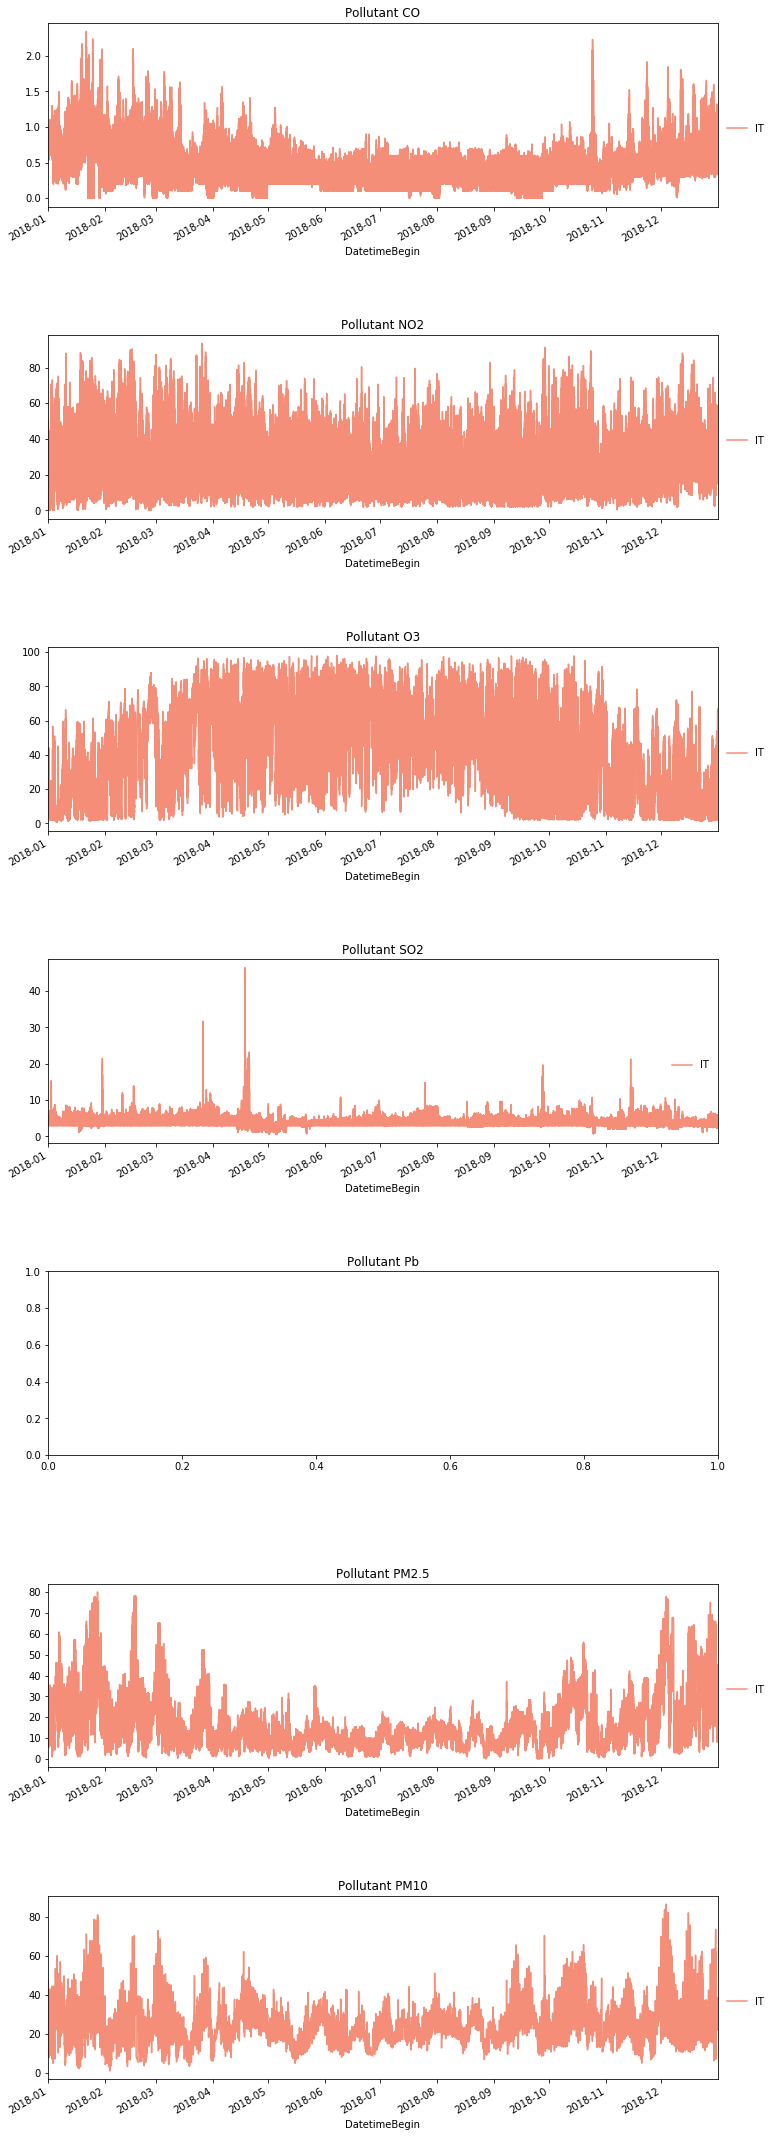

In [16]:
from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage.filters import gaussian_filter1d
ncols = 1
nrows = len(pollutants)
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(12, 6 * nrows))
plt.subplots_adjust(hspace = 0.7)

# For each country, taking by random a certain station
indx = 0
for pollutant in pollutants:
    pollutant = pollutant.split('/')[1]
  
    for country in ['IT']:
        countryData = countries_data[ countries_data.Countrycode == country ]
        countryData = countryData [ countryData.AirPollutant == pollutant ]
        countryData = countryData [ countryData.Concentration < 100 ]
        if countryData.Concentration.count() == 0:
            continue
            
        print(f"stations: {countryData.AirQualityStation.unique()}")
        station = countryData.iloc[0].AirQualityStation
        # measurementsForStation = countries_data[ countries_data.AirQualityStation == station ].copy()
        measurementsForStation = countryData.copy()
        print(f"country {country}, pollutant {pollutant}, station {station} -> count: {measurementsForStation.Concentration.count()}")
        
        measurementsForStation['ConcentrationSmooth'] = gaussian_filter1d(measurementsForStation.Concentration, sigma=1)
        measurementsForStation.ConcentrationSmooth.plot(ax = axes[indx], label = country, alpha = 0.7, color=['#f05f40'])

        
    axes[indx].legend( frameon=False,  bbox_to_anchor=(1.0, 0.5))
    axes[indx].title.set_text(f"Pollutant {pollutant}")
    indx += 1


In [17]:
countryData.AirPollutant.describe()

count     9838
unique       1
top       PM10
freq      9838
Name: AirPollutant, dtype: object

We are going to compute a ranking with all the values


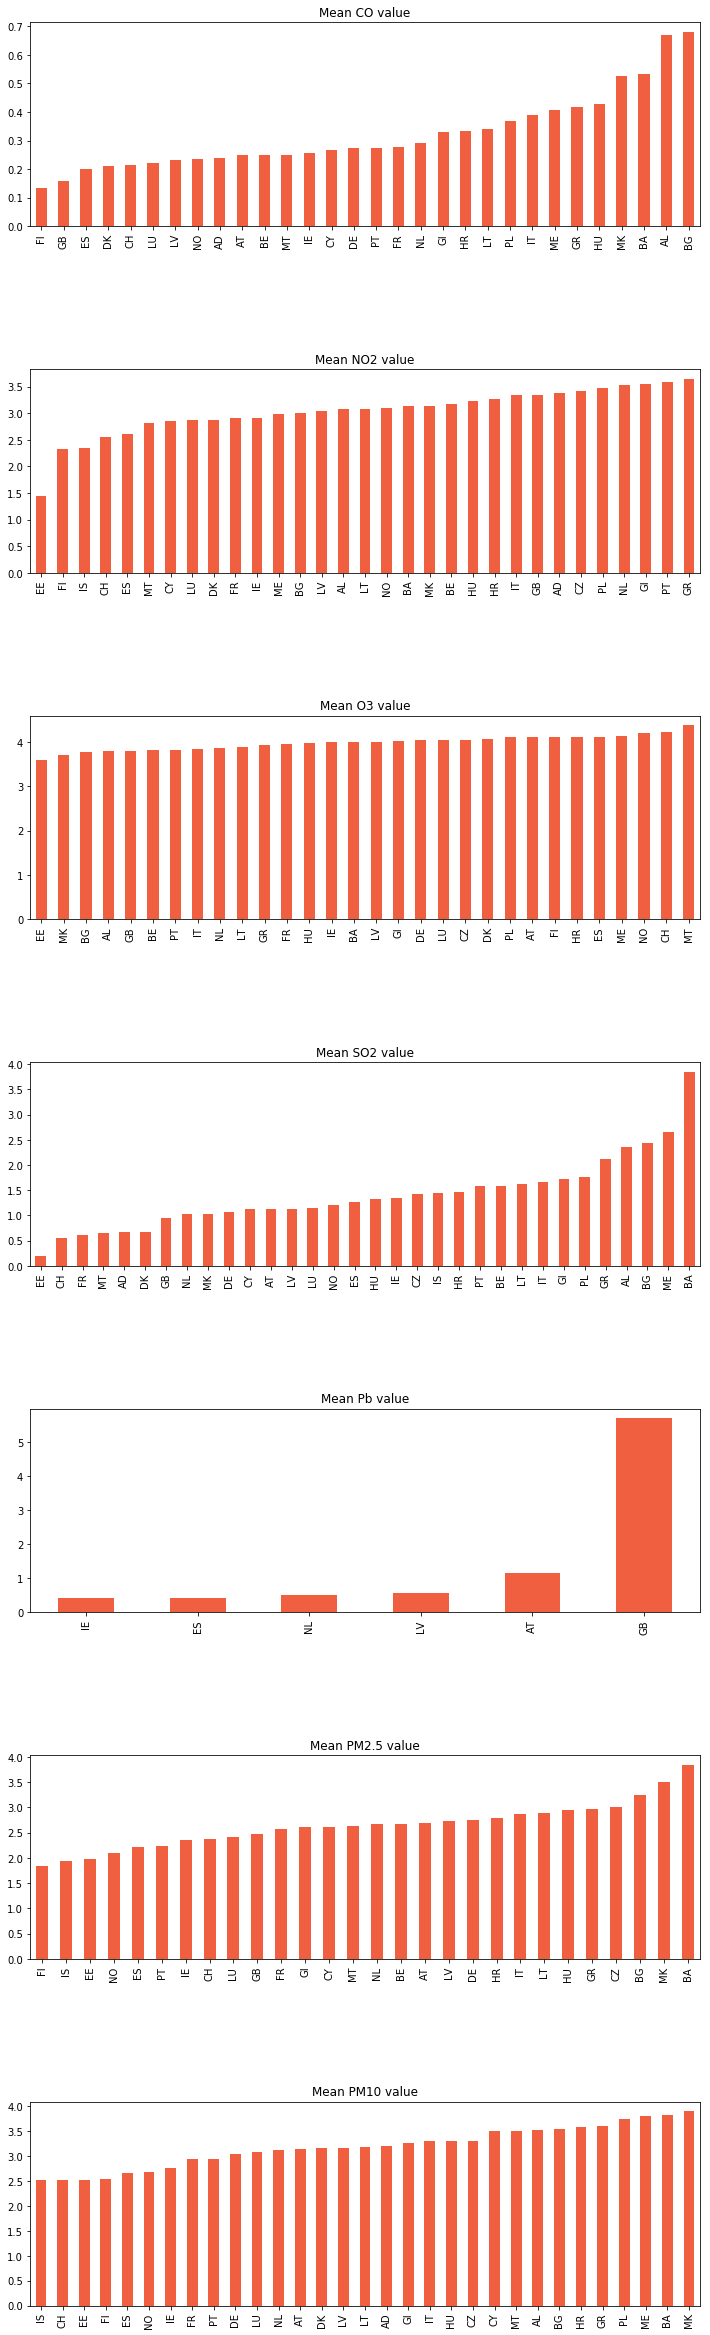

In [19]:
import math
ncols = 1
nrows = len(pollutants)
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(12, 6 * nrows))
plt.subplots_adjust(hspace = 0.7)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# For each country, taking by random a certain st
# ation
indx = 0
for pollutant in pollutants:
    pollutant = pollutant.split('/')[1]
    
    packed = []
    i = 0
    for country in countries:
        countryData = countries_data[ (countries_data.Countrycode == country) & (countries_data.AirPollutant == pollutant) & (countries_data.Concentration < 1000) ]
        computedMean = countryData.Concentration.mean()
        if math.isnan(computedMean):
            continue
        packed.append( (computedMean, country, colors[0]) )
        i += 1
    packed = sorted(packed, key=lambda x: x[0])
    
    sortedMean = []
    sortedCountry = []
    sortedColors = []
    for val in packed:
        sortedMean.append(val[0])
        sortedCountry.append(val[1])
        sortedColors.append(val[2])
        
    concentrationSeries = np.log(pd.Series(sortedMean) + 1)

    concentrationSeries.plot.bar(ax = axes[indx], color=['#f05f40'])
    
    axes[indx].title.set_text(f"Mean {pollutant} value")
    axes[indx].set_xticklabels(sortedCountry)
    indx += 1


In [21]:
countries_data = pd.read_pickle("./countried_timestory_data.pkl")

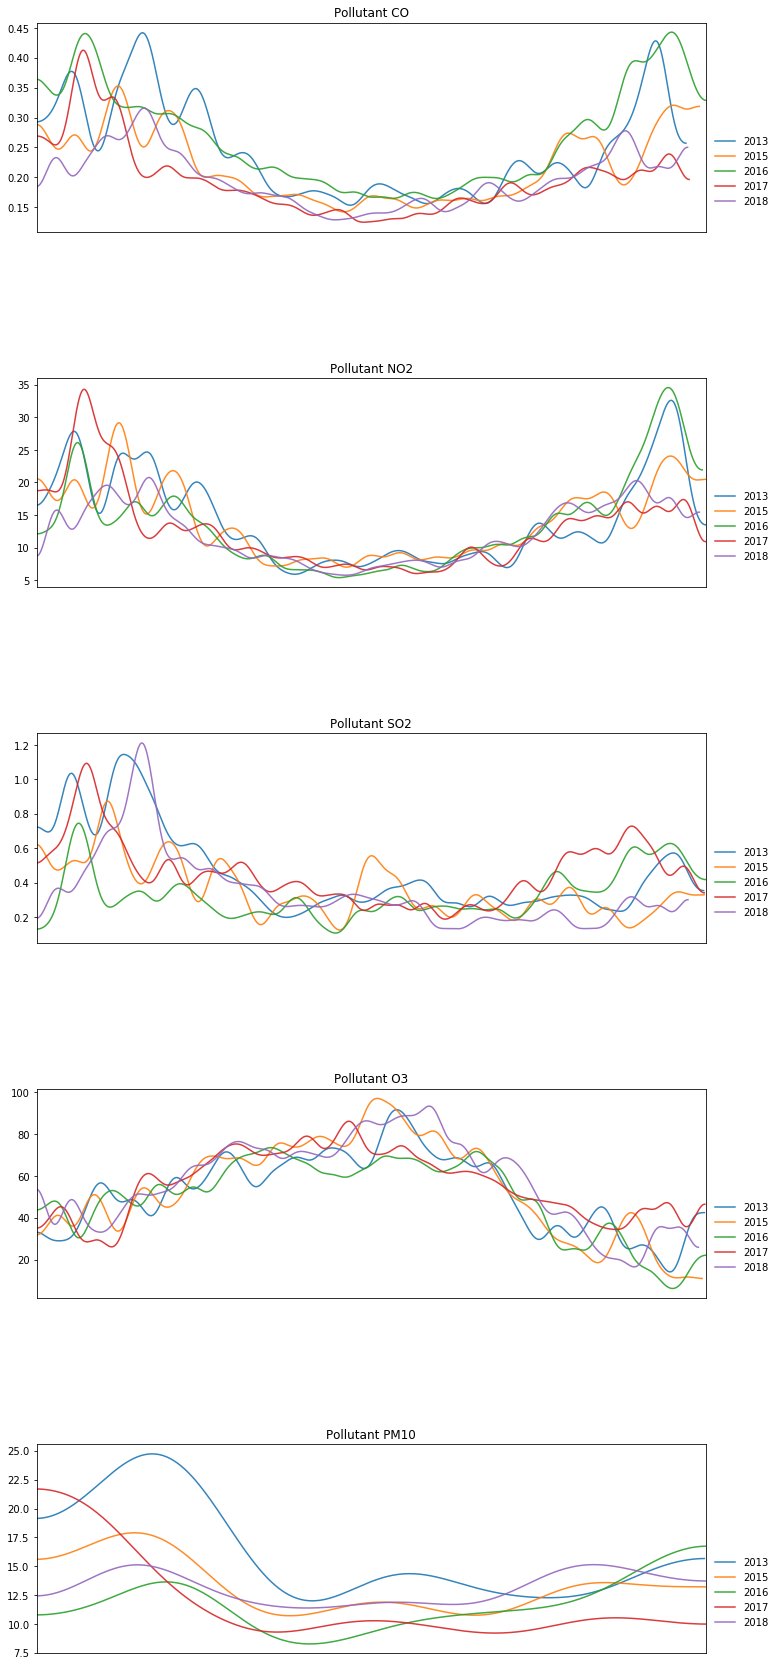

In [23]:
pollutants = ['/CO/', '/NO2/', '/SO2', '/O3', '/PM10']
ncols = 1
nrows = len(pollutants)
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(12, 6 * nrows))
plt.subplots_adjust(hspace = 0.7)

indx = 0
sigmas = [130, 130, 130, 130, 30]

tags = []
means = []
stds = []
for pollutant in pollutants:
    pollutant = pollutant.split('/')[1]
    dataByPollutant = countries_data[ countries_data.AirPollutant == pollutant ]
    dataByPollutant = dataByPollutant.loc[~dataByPollutant.index.duplicated(keep='first')]
    
    crtTags = []
    crtMeans = []
    crtStds = []
    for year in range(2013, 2019):
        if year == 2014:
            continue
        thisYear = str(year) + '-01-01 00:00:00+0100'
        nextYear = str(year + 1) + '-01-01 00:00:00+0100'

        dataInYear = dataByPollutant.loc[ thisYear : nextYear ]
        dataInYear = dataInYear.reset_index(drop=True)
        
        # Gather data for bar plots
        crtTags.append(str(year))
        crtMeans.append(dataInYear.Concentration.mean())
        crtStds.append(dataInYear.Concentration.std())
        
        if dataInYear.shape[0] == 0:
            continue

        dataInYear['ConcentrationSmooth'] = gaussian_filter1d(dataInYear.Concentration, sigma=sigmas[indx])
        dataInYear.ConcentrationSmooth.plot(ax = axes[indx], label = str(year), alpha = 0.9)
    
    tags.append(crtTags)
    means.append(crtMeans)
    stds.append(crtStds)

    axes[indx].legend( frameon=False,  bbox_to_anchor=(1.0, 0.5))
    axes[indx].title.set_text(f"Pollutant {pollutant}")
    axes[indx].set_xticks([])
    indx += 1
    

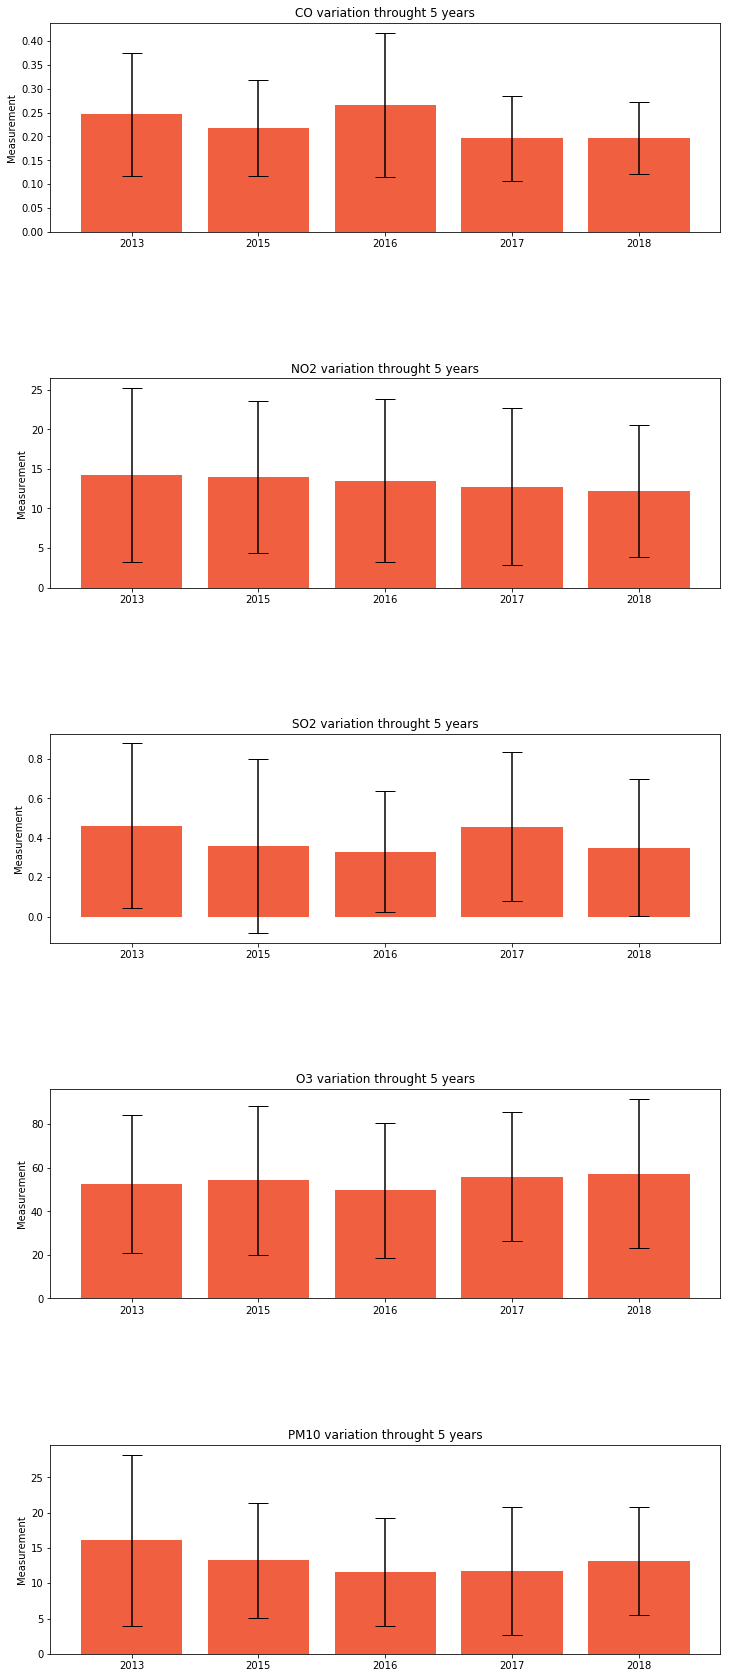

In [24]:
ncols = 1
nrows = len(pollutants)
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(12, 6 * nrows))
plt.subplots_adjust(hspace = 0.7)

for i in range(len(pollutants)):
    pollutant = pollutants[i].split('/')[1]
    crtTags = tags[i]
    crtMeans = means[i]
    crtStds = stds[i]
    
    axes[i].bar(crtTags, crtMeans, yerr=np.array(crtStds), align='center', alpha=1.0, ecolor='black', color = ['#f05f40'], capsize=10)
    axes[i].set_ylabel('Measurement')
    # axes[i].set_xticks(x_pos)
    # axes[i].set_xticklabels(materials)
    axes[i].set_title(pollutant + ' variation throught 5 years')
    axes[i].yaxis.grid(False)